Load, clean and normalize the df

In [1]:
from scripts.preprocess_data import *
df = load_data()
df = clean_data(df)
df = normalize_data(df)

### User Analysis

Number of unique users

In [7]:
# Calculate the number of unique users
unique_users = df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")


Number of unique users: 46755


Most active users

In [8]:
# Identify users with the highest activity
user_activity = df.groupby('user_id').size().reset_index(name='post_count')
top_users = user_activity.sort_values(by='post_count', ascending=False).head(10)
print("Top 10 users with the highest activity:")
print(top_users)

Top 10 users with the highest activity:
          user_id  post_count
4977   1010626427         837
36375  1077881120         178
3600   1007690223         134
14652  1031499948         123
25885  1055454345         116
22969  1049151527         102
38140  1081539622          91
31734  1068051022          86
10609  1022561255          76
3568   1007621559          75


### Network Analysis

Load graph

In [9]:
import networkx as nx

# Load the user connection df
graph_data = pd.read_csv("./data/graph.csv")

# Create an undirected graph using the source and target columns
G = nx.from_pandas_edgelist(graph_data, source='source', target='target')

Degree Centrality

In [10]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 users by degree centrality:")
for user, centrality in top_degree_centrality:
    print(f"User: {user}, Centrality: {centrality}")

Top 10 users by degree centrality:
User: 1010626427, Centrality: 0.038144637978142076
User: 1027710225, Centrality: 0.001131318306010929
User: 1018042330, Centrality: 0.0010459357923497269
User: 1030048137, Centrality: 0.0010459357923497269
User: 1084949174, Centrality: 0.0009818989071038251
User: 1066276793, Centrality: 0.0009818989071038251
User: 1090990902, Centrality: 0.0009818989071038251
User: 1059101695, Centrality: 0.0009818989071038251
User: 1047703640, Centrality: 0.0009605532786885246
User: 1004360689, Centrality: 0.0009178620218579235


Clustering Coefficients

In [11]:
# Calculate clustering coefficients
clustering_coefficients = nx.clustering(G)
avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
print(f"Average clustering coefficient: {avg_clustering_coefficient}")


Average clustering coefficient: 0.10242240045186507


Visualize the User Connections

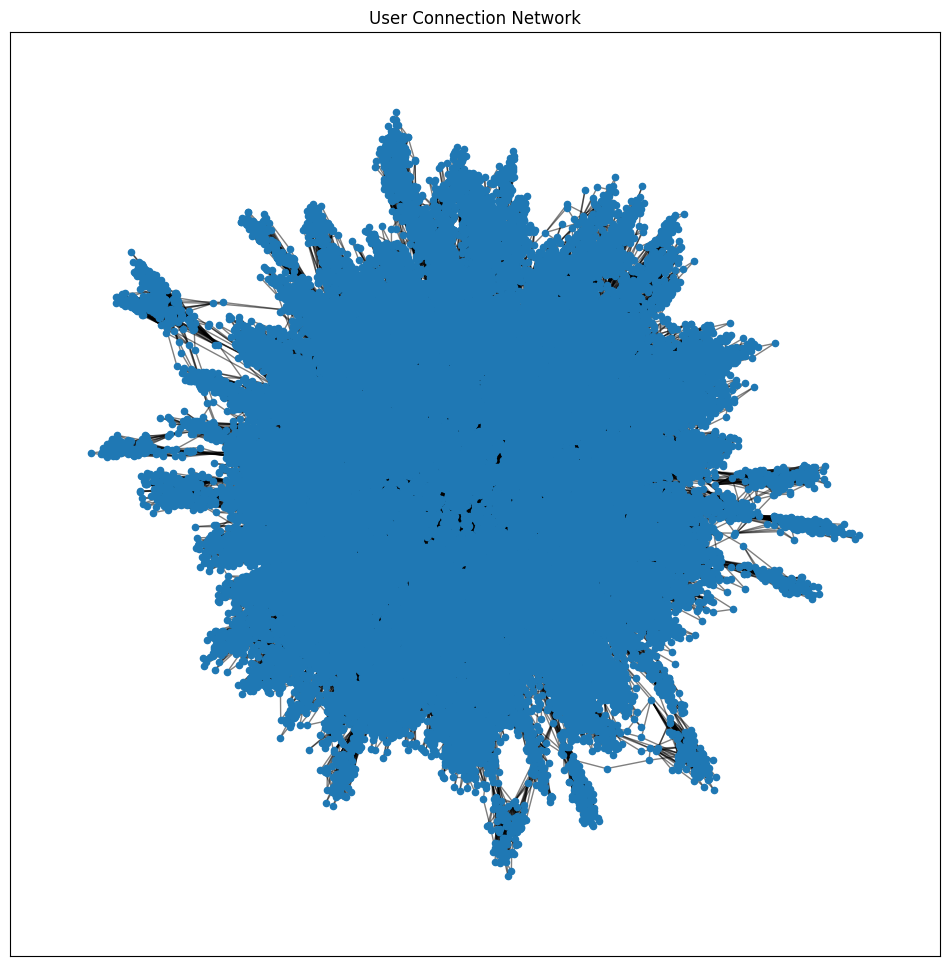

In [12]:
import matplotlib.pyplot as plt

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Positions for nodes
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("User Connection Network")
plt.show()

The visualization from the task description could be replicated.

Closeness and Betweenness Centrality

In [13]:
# Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by closeness centrality:")
for user, centrality in top_closeness:
    print(f"User: {user}, Centrality: {centrality}")

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by betweenness centrality:")
for user, centrality in top_betweenness:
    print(f"User: {user}, Centrality: {centrality}")


Top 10 users by closeness centrality:
User: 1010626427, Centrality: 0.30633022303884705
User: 1077997466, Centrality: 0.2364615563216418
User: 1021402235, Centrality: 0.2362290485891204
User: 1028635896, Centrality: 0.23563377377186057
User: 1043529958, Centrality: 0.23560296314177517
User: 1089906253, Centrality: 0.23549163805626908
User: 1001396520, Centrality: 0.23531420936575467
User: 1076700886, Centrality: 0.23517600048191803
User: 1032319872, Centrality: 0.23507569409249884
User: 1032811749, Centrality: 0.23505918124664454

Top 10 users by betweenness centrality:
User: 1010626427, Centrality: 0.9896298288685079
User: 1038230812, Centrality: 0.0070046515806957525
User: 1077997466, Centrality: 0.006013904448260786
User: 1019871970, Centrality: 0.005927335450255653
User: 1032319872, Centrality: 0.005910679364671109
User: 1075438118, Centrality: 0.005775643947694998
User: 1001396520, Centrality: 0.005432906779826888
User: 1037467053, Centrality: 0.005375260064014553
User: 104697458

Community Detection

Detected communities: 247


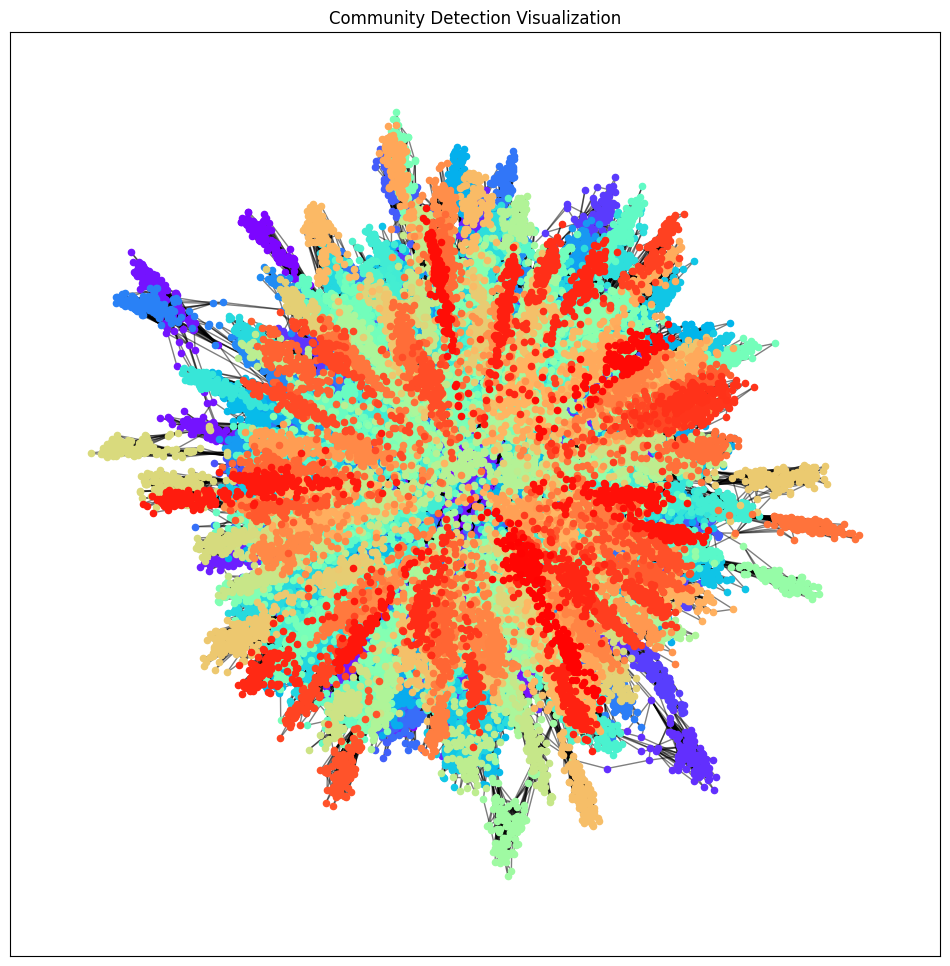

In [14]:
from community import community_louvain

# Louvain community detection
partition = community_louvain.best_partition(G)
print(f"Detected communities: {len(set(partition.values()))}")

# Add nodes to communities
for node, community in partition.items():
    G.nodes[node]['community'] = community

# Visualize communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
communities = set(partition.values())
colors = plt.cm.rainbow([i / len(communities) for i in range(len(communities))])

for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(
        G, pos, nodelist=[node for node in partition if partition[node] == community],
        node_size=20, node_color=[color]
    )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Community Detection Visualization")
plt.show()